#Shape detection experiment (DenseNet up close: Training-set 80k examples, Confidence accuracy 99%, Classification accuracy 99%, IoU 90%)
For its purposes, the experiment ended with part III. However, I wanted to explore the potential of one of the examined network: the DenseNet201. At the end of a training on 80 thousand examples I obtained important results and this prompted me to analyze the neural network more closely.

The structure of this Part of the experiment is as follows:
___

###Part IV (DenseNet up close)
- Loading data and model
- Make prediction and analysis
___

In [0]:
# Import some useful library
from google.colab import drive
import h5py
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

# Import tensorflow and keras
import tensorflow as tf
from tensorflow import keras

# Import matplotlib functionality 
import matplotlib.pyplot as plt
from matplotlib import gridspec, patches
from matplotlib.colors import ListedColormap

#Part III


##Loading data
We load the Test-set and the neural network model for which we want to see the performances

In [0]:
# mount our workdrive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# general path 
path = '/content/drive/My Drive/'
# data path with datasets names
data_path = 'Colab_data/'
data_name = 'XYdata_40k_3bb_testset.h5'

Loading Test-set.

In [0]:
# open data file
xy_h5f = h5py.File(path + data_path + data_name, 'r')

# load data
X_test = np.array(xy_h5f['X_test'])
Y_test = np.array(xy_h5f['Y_test'])
imgs_mean = np.array(xy_h5f['imgs_mean'])
imgs_std = np.array(xy_h5f['imgs_std'])

In [0]:
# close data file
xy_h5f.close()

Let's consider some useful information from our dataset:

In [0]:
# Useful informations about data images 
n_examples = X_test.shape[0]    # number of examples in Test-set
side_dim = X_test.shape[1]      # side dimension for each image
n_bb = Y_test.shape[1] // 6     # bounding boxes for each image

print('Test examples:', X_test.shape[0])
print('Image size:', side_dim, 'x', side_dim)
print('Bounding boxes per image:', n_bb)
print('-------')
print('Images mean:', imgs_mean)
print('Images standard deviation:', imgs_std)

Test examples: 6000
Image size: 64 x 64
Bounding boxes per image: 3
-------
Images mean: 196.2765323384603
Images standard deviation: 18.37592427614397


In [0]:
# possible objects classes in the images 
classes = { 0: '--',  # no-obj, or background-obj 
            1: '+r',  # red cross
            2: '+g',  # green cross
            3: '+b',  # blue cross
            4: '#r',  # red pound 
            5: '#g',  # green pound
            6: '#b',  # blue pound
            7: 'or',  # red square
            8: 'og',  # green square
            9: 'ob',  # blue square
          }

##Loading model
Loading CNN model.

In [0]:
# coordinates loss function
def rmse(y_true, y_pred):
  '''  
  Arguments:
  y_true -- tensor with expected Y
  y_pred -- tensor with predicted Y
  
  Returns:
  euc_dist -- scalar
  '''
  rmse = K.sqrt(K.mean(K.square(y_pred -y_true), axis=-1))
  return rmse

In [0]:
# model path with models names
model_path = 'Colab_models/'
model_name = 'DenseNet201_80k_3bb.h5'
model_filename = path + model_path + model_name

In [0]:
# clear ghraph
tf.keras.backend.clear_session()

# load model
model = keras.models.load_model(model_filename, custom_objects={'rmse': rmse})

In [0]:
model.summary()

## Make predictions


In [0]:
# Predictions from neural network using Test set as input
model_predictions = model.predict(X_test)

Let's break down the predictions and see how the different models of neural network have behaved in each of the three tasks on which we have trained them: obj presence confidence, classification of the identified object and identification of the bounding boxes.

In [0]:
# decompose predictions by different targets (class, confidence, coordinates)
predict_class = model_predictions[0].reshape(n_examples, n_bb, -1)
predict_confidence = model_predictions[1].reshape(n_examples, -1, 1) / 2 + (1/2) # *Remember: we use tanh as activation function 
predict_bboxes = model_predictions[2].reshape(n_examples, n_bb, -1)              

In [0]:
# reshape and convert softmax data to class prediction  
predict_class = predict_class.argmax(-1).reshape(n_examples, n_bb, 1)

# shape of prediction for class, confidence and bboxes coordinates
predict_class.shape, predict_confidence.shape, predict_bboxes.shape

((6000, 3, 1), (6000, 3, 1), (6000, 3, 4))

Now let's go into detail and generalize the behavior of the different models on the whole Test-set for all three tasks.


## Confidence Predictions
Let's consider confidence predictions. This measure should tell us if an object is present or not in the bounding boxing under consideration (more properly it tells us for every bounding boxes if there is an object in the image to be examined and looked for).

In [0]:
# True and Predict value for level of confidence
true_confidence = Y_test[:, 1::6].reshape(-1)
pred_confidence = predict_confidence.reshape(-1)

For our purpose, the degree of confidence assumes binary values. We can therefore make a rounding for the intermediate values so as to fall into them: '0' - no confidence, '1' - total confidence.
(Wanting to do a more in-depth analysis we could later analyze the distribution of predictions and better understand the behavior of confidence the neural network. At the moment this is beyond the scope of our experiment)

In [0]:
# now we consider the strictly and almost equivalence of confidence
src = (pred_confidence == true_confidence)
arc = (np.round(pred_confidence) == np.round(true_confidence))

strictly_right_confidence = np.count_nonzero(src)
almost_right_confidence = np.count_nonzero(arc)

# to see the confidence accuracy we just need the almost results
confidence_accuracy = almost_right_confidence / (n_examples*n_bb)
# Let's also take a look at the strictly confidence accuracy
strictly_confidence_accuracy = strictly_right_confidence / (n_examples*n_bb)

In [0]:
# let's create some mask
# obj not created, obj not to detect (non_obj), obj created
c_zero = (true_confidence == 0)
c_non_obj = (true_confidence == .1)
c_one = (true_confidence == 1)

# strictly obj confidence 
right_c_zero = np.count_nonzero(src * c_zero)
right_c_one = np.count_nonzero(src * c_one)

# almost obj confidence
almost_zero = np.count_nonzero(arc * c_zero) + np.count_nonzero(arc * c_non_obj)
almost_one = np.count_nonzero(arc * c_one)

# wrong confidence prediction
wrong_prediction = (n_examples*n_bb) - np.count_nonzero(arc)

# confidence original/predicted data
confidence_original_data = [c_zero, c_non_obj, c_one]

confidence_predicted_data= [right_c_zero,
                           almost_zero-right_c_zero, 
                           wrong_prediction,
                           almost_one-right_c_one,
                           right_c_one]

# confidence confusion matrix / recall / precision / f1_score
y_true = true_confidence.astype('int16')
y_pred = np.round(pred_confidence).astype('int16')

confidence_confusion_matrix = confusion_matrix(y_true, y_pred)

confidence_precision = precision_score(y_true, y_pred)
confidence_recall = recall_score(y_true, y_pred)
confidence_f1_score = f1_score(y_true, y_pred)

In [0]:
# method to show some data about confidence results
def plot_confidence_data(original_data, 
                        predicted_data, 
                        almost_right_confidence,
                        cc_matrix):
  """
  """
  # Plot true confidence distribution vs predict confidence distribution
  fig = plt.figure(figsize=(12,6))
  plt.title('obj confidence distribution')
  plt.axis('off')

  gs = gridspec.GridSpec(ncols=4, nrows=1, width_ratios=[5, 5, .4, 3]) 
  ax1 = fig.add_subplot(gs[0])
  ax2 = fig.add_subplot(gs[1])
  ax3 = fig.add_subplot(gs[3])

  # pie with objects above_pc_obj, below_pc_obj and no_obj
  ax1.set_title('Real objects distribution')
  explode = [0, 0, 0.1]
  ax1.pie([np.count_nonzero(original_data[0]), # c_zero 
          np.count_nonzero(original_data[1]), # c_non_obj 
          np.count_nonzero(original_data[2])], # c_one 
          autopct='%1.1f%%', explode=explode, colors=[[.7, .4, .8],[.7, .2, .6],[.8, .4, .2]])
  ax1.legend(['objects not created',
              'objects below Pc_th',
              'object above Pc_th'], loc = 'lower left')

  # pie with objects above_pc_obj, below_pc_obj and no_obj
  ax2.set_title('Predict objects distribution')
  explode = [0, 0, .1, 0, 0]
  ax2.pie(predicted_data, 
          autopct='%1.1f%%', explode=explode, colors=[[.55, .45, .0],'y', 'r',[.2, .85, .1],'g'])
  ax2.legend(['right 0',
              'almost 0',
              'wrong', 
              'almost 1',
              'right 1'], loc = 'lower right')

  # confusion matrix
  ax3.set_title('Confusion matrix')
  cmap = 'cividis' #ListedColormap(['r',[.8, .5, .0],'y',[.5, .7, .0],'g'])
  ax3.imshow(cc_matrix, cmap=cmap)
  ax3.set_xlabel('predictions')
  ax3.set_xticks([0,1])
  ax3.set_xticklabels([0, 1])
  ax3.set_ylabel('true values')
  ax3.set_yticks([0,1])
  ax3.set_yticklabels([0, 1])
  for i in range(cc_matrix.shape[0]):
    for j in range(cc_matrix.shape[1]):
      ax3.text(j, 
               i, 
               cc_matrix[i,j], 
               color=[.8,.4,.1], 
               fontsize=14, 
               horizontalalignment='center',
               verticalalignment='bottom')
      if i == j:
        ax3.text(j, 
                 i, 
                 "{:.0%}".format(cc_matrix[i,j]/almost_right_confidence), 
                 color=[.8,.4,.1], 
                 fontsize=11, 
                 horizontalalignment='center',
                 verticalalignment='top')
  
  ax3.text(1.9, 0, 'Precision ' + "{:.2f}".format(confidence_precision),
        bbox={'facecolor': 'y', 'alpha': 0.15, 'pad': 3})
  ax3.text(1.9, .5, 'Recall ' + "{:.2f}".format(confidence_recall), style='italic',
        bbox={'facecolor': 'y', 'alpha': 0.15, 'pad': 3})
  ax3.text(1.9, 1, 'F1_Score ' +  "{:.2f}".format(confidence_f1_score), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.2, 'pad': 3})
  plt.show()

With 80k examples DenseNet easily achieves an accuracy of over 99%. As we have already seen in Part III, we are not very interested in the Strictly confidece accuracy value, all models tend to give almost 0 and almost 1 values for the most part, but this also depends on the loss function we used (CategoricalHinge). More interesting to see that the algorithm has a higher Recall than the Preicision, (there are more False Positives than False Negatives). But for both metrics, these are still values greater than .99.

In [0]:
# DenseNet201 (7.2M params x 201 layers) 80k 70ep
print('Strictly confidence accuracy:', strictly_confidence_accuracy)
print('Confidence accuracy:', confidence_accuracy)

Strictly confidence accuracy: 0.06605555555555556
Confidence accuracy: 0.9923333333333333


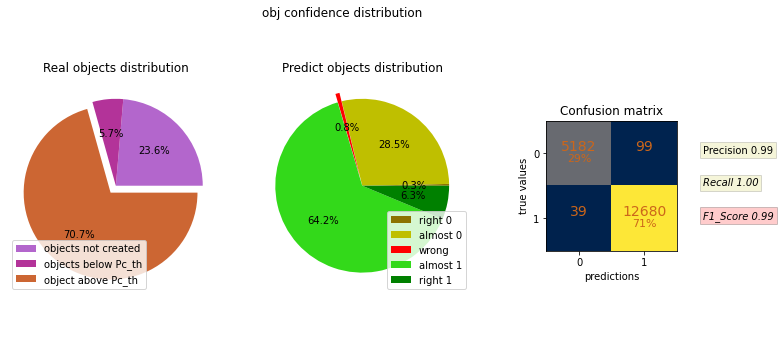

In [0]:
# DenseNet201 (7.2M params x 201 layers) 80k 70ep
plot_confidence_data(confidence_original_data, 
                    confidence_predicted_data,
                    almost_right_confidence, 
                    confidence_confusion_matrix)

## Class predictions
Now let's evaluate the predictions regarding the classification of the different objects, remember that we have nine classes (red cross, green cross, blue cross, red pound, green pound, blue pound, red square, green square, blue square) plus a tenth in case of background (when we have no objects or the objects belong to the background and on the basis of our Pc_th they don't have to be classified)

classes = {0: '---', 1: '+r', 2: '+g', 3: '+b', 4: '#r', 5: '#g', 6: '#b ', 7:' or ', 8:' og ', 9:' ob '}

In [0]:
true_class = Y_test[:, 0::6].reshape(-1).astype('int8')
pred_class = predict_class.reshape(-1).astype('int8') 

In [0]:
# Number of correctly classified objects (absolute and average value)
obj_to_identify = np.count_nonzero(true_class > 0)
obj_identified = np.count_nonzero((true_class == pred_class)*(true_class > 0))

# non-object correctly identify
nonobj_identified = np.count_nonzero((true_class == pred_class)*(true_class == 0))

# overall identification
overall_identification = np.count_nonzero(true_class == pred_class)

# Errors
wrong_classification = np.count_nonzero(true_class != pred_class)

# Accuracy
accuracy_obj_identified = obj_identified / np.count_nonzero(true_class > 0)
accuracy_overall_identified = overall_identification / (n_examples*n_bb)

In [0]:
# Precision, Recall, F1_score
c_report = classification_report(true_class, pred_class, target_names=list(classes.values()))
class_confusion_matrix = confusion_matrix(true_class, pred_class)

In [0]:
def plot_cassification_data(classes, true_class, pred_class, class_confusion_matrix):
  cl = classes.values()
  ticks = np.arange(0,10)

  fig = plt.figure(figsize=(14,6))
  plt.axis('off')

  gs = gridspec.GridSpec(ncols=5, nrows=5, width_ratios=[1.1,.2,1.8,.3,.9]) 
  ax1 = fig.add_subplot(gs[1:4,0])
  ax2 = fig.add_subplot(gs[:,2])
  ax3 = fig.add_subplot(gs[:,4])

  # Plot Histogram obj classes distribution
  bins = np.arange(0, 11, 1)
  ax1.hist([true_class, pred_class], bins=bins-0.5, color=('y','g'))
  ax1.set(title='obj real classes / predictions', xlabel='classes', ylabel='num examples')
  ax1.set_xticks(ticks=bins) 
  ax1.set_xticklabels(cl)
  ax1.legend(['Real class','Predicted class'])

  # confusion matrix
  ax2.set_title('Confusion matrix')

  cmap = 'cividis'
  ax2.imshow(class_confusion_matrix, cmap=cmap)
  ax2.set_xlabel('predicted classes')
  ax2.set_xticks(ticks)
  ax2.set_xticklabels(cl)
  ax2.set_ylabel('true classes')
  ax2.set_yticks(ticks)
  ax2.set_yticklabels(cl)
  for i in range(class_confusion_matrix.shape[0]):
    for j in range(class_confusion_matrix.shape[1]):
      ax2.text(j, i ,class_confusion_matrix[i,j], color=[.8,.4,.1], fontsize=10, horizontalalignment='center',)

  ax3.axis('off')
  ax3.text(0.5, .5, c_report, wrap=True, horizontalalignment='center', verticalalignment='center', fontsize=12)
  plt.show()

We had already seen how in classifying DenseNet objects it gave rather uniform results. A trend that is confirmed, there are no objects that are confused more than the others after a training on 80k examples. Looking closely at the confusion matrix, the only two-digit error (12 cases) concerns '#b' indicated by the network as non-objects which are revealed in the '#b' Recall at .98 instead of .99 like all other classes. We are at 99% overall accuracy with the correct detection of 5262 non-objects out of 5281.

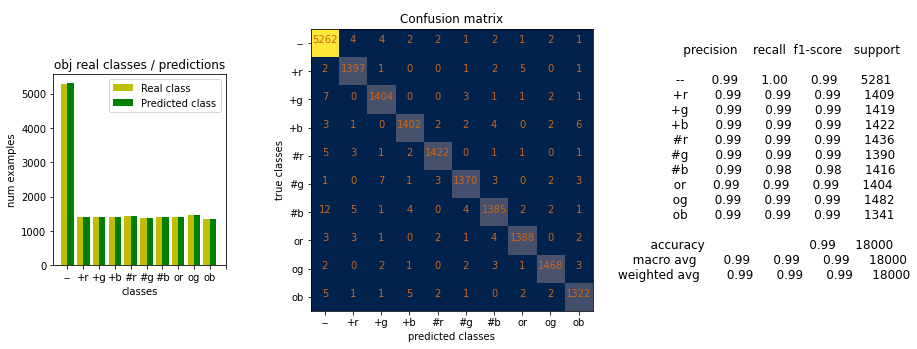

In [0]:
# DenseNet201 (7.2M params x 201 layers) 80k 70ep
plot_cassification_data(classes, true_class, pred_class, class_confusion_matrix)

In [0]:
# DenseNet201 (7.2M params x 201 layers) 80k 70ep
print('Correct obj class identified:', obj_identified, 'on', (np.count_nonzero(true_class > 0)))
print('Non-obj identified: ', nonobj_identified, 'on', (np.count_nonzero(true_class == 0)),'\n')
print('Accuracy in obj identification:', accuracy_obj_identified)
print('Overall accuracy (considering non-obj):', accuracy_overall_identified)

Correct obj class identified: 12558 on 12719
Non-obj identified:  5262 on 5281 

Accuracy in obj identification: 0.9873417721518988
Overall accuracy (considering non-obj): 0.99


## Coordinates predictions


In [0]:
def IoU(box1, box2):
  '''  
  Arguments:
  box1 -- first box, with coordinates (x, y, w, h)
  box2 -- second box, with coordinates (x2, y2, w2, h2)
  
  Returns:
  iou -- scalar
  '''    
  [x, y, w, h] = box1
  [x2, y2, w2, h2] = box2
  # Intesection area 
  xi1 = np.maximum(x, x2)
  yi1 = np.maximum(y, y2)
  xi2 = np.minimum(x+w, x2+w2)
  yi2 = np.minimum(y+h, y2+h2)
  xi = np.maximum(0., xi2-xi1)
  yi = np.maximum(0., yi2-yi1)
  
  inter_area = np.multiply(xi,yi)

  # Union area
  box1_area = (w*h)
  box2_area = (w2*h2)
  union_area = box1_area+box2_area-inter_area
  
  # Calculation of IoU
  iou = inter_area/union_area
  return iou

In [0]:
# The average IoU of the whole dataset
def mean_IoU(expe_bboxes, pred_bboxes):
  '''  
  Arguments:
  expe_bboxes -- np.array(dim_test, n_bb, 5), expected bounding boxes 
  pred_bboxes -- np.array(dim_test, n_bb, 5), predicted bounding boxes 
  
  Returns:
  iou -- scalar, value of Intersection over Union of the whole dataset
  '''    
  
  expe = expe_bboxes.reshape(-1,6)
  pred = pred_bboxes.reshape(-1,6)
  total_bb = expe.shape[0] 

  iou_global = 0
  real_bb = 0
  for i in range(total_bb):
    [eCl, _, x , y, w, h] = expe[i, :] 
    [cl, _, x2, y2, w2, h2] = pred[i, :]  
    if cl == 0:
      pass
    else: 
      iou_global += IoU([x,y,w,h], [x2,y2,w2,h2])
      real_bb += 1

  iou_global /= real_bb
  return iou_global

In [0]:
# The average center of the object in bounding box accuracy of the whole dataset 
def accuracy_centre(expe_bboxes, pred_bboxes):
  '''  
  Arguments:
  expe_bboxes -- np.array(dim_test, N_bb, 5), expected bounding boxes 
  pred_bboxes -- np.array(dim_test, N_bb, 5), predicted bounding boxes 
  
  Returns:
  iou -- scalar, value of Intersection over Union of the whole dataset
  '''    
  
  expe = expe_bboxes.reshape(-1,6)
  pred = pred_bboxes.reshape(-1,6)
  total_bb = expe.shape[0] 

  acc_global = 0
  real_bb = 0
  for i in range(total_bb):
    [cl, _, x , y, w, h] = expe[i, :] 
    [eCl, _, x2, y2, w2, h2] = pred[i, :]  
    if eCl == 0:
      pass
    else: 
      centreX = x+(w/2)
      centreY = y+(h/2)
      real_bb += 1
      acc_global += (x2 < centreX < x2+w2) and (y2 < centreY < y2+h2)

  acc_global /= real_bb

  return acc_global

In [0]:
# concatenate reshaped predictions to use during visualization
pred_bboxes = np.concatenate((predict_class, predict_confidence, predict_bboxes), 2)

# reshaped expected bboxes of our Validation set
expe_bboxes = Y_test.reshape(n_examples, n_bb, -1)

In [0]:
def visualize_predictions(n_visual, rand_examples, iou_tr, imgTest, pred_bboxes, expe_bboxes):
    '''
    Arguments:
    ax -- plot image
    img -- np.array(side_dim,side_dim,3), an image
    bboxes -- np.array(n_bb,6), predicted bounding boxes
    expe_bboxes -- np.array(n_bb,6), expected bounding boxes
    iou_tr -- scalar, IoU treshold

    Returns:
    None
    '''
    # image side dimension
    side_dim = imgTest.shape[1]

    # number of bounding boxes
    n_bb = pred_bboxes.shape[1]

    # show predictions
    fig = plt.figure(figsize=(18,8))
    for i in range (n_visual):
      
      # We take a random image of our training set
      im = rand_examples[i]
      ax = fig.add_subplot((n_visual//4)+1,4, i+1)
      ax.grid( which='both', color='w', linestyle=':')
      plt.xticks(np.arange(0, side_dim, step=10))
      ax.set_title('Imagine n.' + str(im))

      img = imgTest[im]
      pred = pred_bboxes[im]
      expe = expe_bboxes[im]

      # We look at the objects contained in it...
      ax.imshow(img, origin='upper', extent=[0, side_dim, side_dim, 0])

      # ...and the bounding boxes predicted by the algorithm
      print(' _______________________________________________________________ ')
      print(f'| Image:{im:6d}                   |       expected/predicted     |')
      for j in range(n_bb):
          [Cl, Pc, x, y, w, h] = pred[j]
          Cl = classes[int(round(Cl))]
          Pc = int(round(Pc))
          

          [eCl, ePc, x2, y2, w2, h2] = expe[j, :]
          eCl = classes[int(round(eCl))]
          ePc = int(round(ePc))
          iou_bb = IoU([x, y, w, h], [x2, y2, w2, h2])
          
          if Pc == 0:
            rect = patches.Rectangle((x, y), w, h, ec='tab:blue', lw='1.4', fc='none')
          else:
            if iou_bb >= iou_tr:
                rect = patches.Rectangle((x, y), w, h, ec='tab:red', lw='1.4', fc='none')
                dida = 'IoU: ' + '{:0.3f} '.format(iou_bb)
                plt.annotate(dida + Cl, (x + w, y + 0.8), color='tab:red')

            else:
                rect = patches.Rectangle((x, y), w, h, ec='tab:green', lw='1.4', fc='none')

          ax.add_patch(rect)
          print(f'| Object bounding Box IoU: {iou_bb:5.1%} | confidence {ePc:1d}/{Pc:1d} | class {eCl}/{Cl} |')
    plt.show()

In [0]:
# Image decoding from normalized dataset
imgTest = ((np.reshape(X_test, (n_examples, side_dim, side_dim, 3)) * imgs_std) + imgs_mean)/255

In [0]:
# Internent over Union treshold to consider valid Bounding Boxes
iou_tr = .3

# We look at n_visual random images of our Validation set and at the bounding boxes predicted by the algorithm
n_visual = 3

# take n_visual random examples
rand_examples = np.random.randint(n_examples, size = (n_visual,))


> *** We use the examples that we got in Part III to compare the behavior of the different models


In [0]:
# Same random examples for other models***  
rand_examples = [1700, 2732, 1736]

This time let's take a look at the bounding boxes before seeing our reference metrics (Mean IoU and Mean xy-center Acccuracy). As we see using the same examples that we had seen in Part III, the network performs very well almost everywhere. The only anomalous case is the green box in the second image, the neural network continues to be 'disturbed' by the non-object on the right (non-object which, moreover, is correctly indicated as such by the confidence detector and classifier). For other objects the IoU is always higher than 80% and in one case it reaches 98.2%. 

 _______________________________________________________________ 
| Image:  1700                   |       expected/predicted     |
| Object bounding Box IoU: 88.1% | confidence 1/1 | class ob/ob |
| Object bounding Box IoU: 91.7% | confidence 1/1 | class +r/+r |
| Object bounding Box IoU: 82.0% | confidence 1/1 | class +r/+r |
 _______________________________________________________________ 
| Image:  2732                   |       expected/predicted     |
| Object bounding Box IoU: 91.6% | confidence 1/1 | class +b/+b |
| Object bounding Box IoU: 13.9% | confidence 1/1 | class or/ob |
| Object bounding Box IoU:  0.0% | confidence 0/0 | class --/-- |
 _______________________________________________________________ 
| Image:  1736                   |       expected/predicted     |
| Object bounding Box IoU: 98.2% | confidence 1/1 | class #r/#r |
| Object bounding Box IoU: 89.0% | confidence 1/1 | class og/og |
| Object bounding Box IoU: 88.3% | confidence 1/1 | class ob/ob |


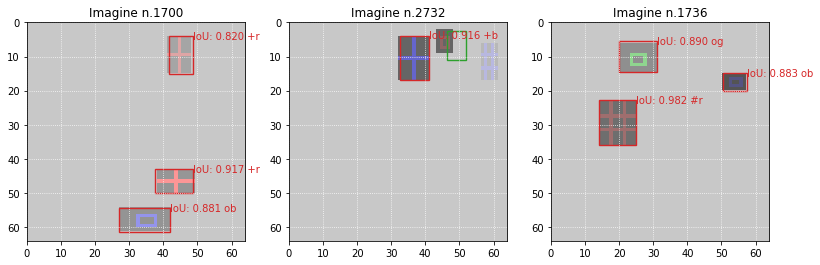

In [0]:
# DenseNet201 (7.2M params x 201 layers) 80k 70ep
visualize_predictions(n_visual, rand_examples, iou_tr,
                      imgTest, 
                      pred_bboxes, expe_bboxes)

This as we see translates into a Mean IoU of over 90% and an Mean xy-center Accuracy of almost 99%. Below we look at other examples (this time really random from the dataset).

In [0]:
m_iou = mean_IoU(expe_bboxes, pred_bboxes)
m_acc = accuracy_centre(expe_bboxes, pred_bboxes)

In [0]:
# DenseNet201 (7.2M params x 201 layers) 80k 70ep
print('Test-set mean IoU is:       ', m_iou)
print('Test-set mean xy-center Acc:', m_acc, '\n')

Test-set mean IoU is:        0.9008978105288423
Test-set mean xy-center Acc: 0.989210899354229 



In [0]:
# We look at n_visual random images of our Validation set and at the bounding boxes predicted by the algorithm
n_visual = 4

# take n_visual random examples
rand_examples = np.random.randint(n_examples, size = (n_visual,))

 _______________________________________________________________ 
| Image:  1910                   |       expected/predicted     |
| Object bounding Box IoU: 94.4% | confidence 1/1 | class or/or |
| Object bounding Box IoU: 94.6% | confidence 1/1 | class #r/#r |
| Object bounding Box IoU:  0.0% | confidence 0/0 | class --/-- |
 _______________________________________________________________ 
| Image:  1865                   |       expected/predicted     |
| Object bounding Box IoU: 95.0% | confidence 1/1 | class #g/#g |
| Object bounding Box IoU: 93.1% | confidence 1/1 | class og/og |
| Object bounding Box IoU: 97.8% | confidence 1/1 | class or/or |
 _______________________________________________________________ 
| Image:  4931                   |       expected/predicted     |
| Object bounding Box IoU: 95.3% | confidence 1/1 | class +b/+b |
| Object bounding Box IoU: 84.9% | confidence 1/1 | class #r/#r |
| Object bounding Box IoU:  0.0% | confidence 0/0 | class --/-- |
 _________

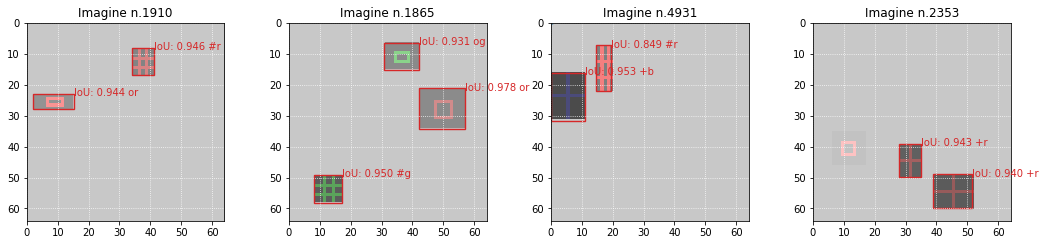

In [0]:
# DenseNet201 (7.2M params x 201 layers) 80k 70ep
visualize_predictions(n_visual, rand_examples, iou_tr,
                      imgTest, 
                      pred_bboxes, expe_bboxes)

<br/>
<br/>
<br/>
